# Behavorial-Cloning Project
## - Brian Erickson
This is my implementation of the Udacity Self Driving Car class project "Behavioral Cloning".

The goal is to record driving input and images using a driving simulator, use the recorded input and images to train a neural network that will predict steering angles and then use the predicted steering angles to drive the same car in the same simulator.

Installation: This is a linux based implementation.  The linux simulator should be installed in ../simulator

### Imports and Helper Functions

The helper functions below will be used throughout the notebook.

todo:
* make generator that uses file paths
* get file paths of all files self generated
* create validation set from own files

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import math
import time
import skimage.transform
import random
import os
from ipywidgets import widgets
from IPython.display import display
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout, Flatten
from keras.layers import Dense, Lambda, SeparableConvolution2D, Dense
from keras.activations import relu, elu

%matplotlib inline

Using TensorFlow backend.


In [2]:
# to make "random" calls predictable, use a fixed seed
# since I'm using random from  numpy, tensorflow and from the 
# standard python random, I have a single seed helper
# that will take care of all
def seed(n=32568):
    """
    Seeds the random number generators
    """
    np.random.seed(n)
    random.seed(n)
    tf.set_random_seed(n)

In [3]:
# based on http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
# and modified
def smooth(x, window_len=11, window='hanning'):
    """
    returns a smoothed version of x.
    
    Ends are padded with reflections

    input:
        x: 1d array
        window_len: smoothing window length; should be an odd integer
        window: kernel type: 'flat', 'hanning', 'hamming', 'bartlett', 'blackman' 

    output:
        the smoothed signal, same size as x
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[window_len//2:x.size+window_len//2]

In [4]:
def plot_image(img,title=None):
    '''
    Plots a single RGB or Greyscale image with no border
    '''
    cmap = 'gray' if np.ndim(img) == 2 else None
    plt.axis('off')
    plt.imshow(img, cmap=cmap, interpolation='none')
    if title is not None:
        plt.title(title)
        
def plot_images(l, images_per_line = 10, image_size_inches = 1.0, title=None):
    """
    Plots images in a grid
    """
    fig=plt.figure()
    if title is not None:
        fig.suptitle(title)
    line_count=math.ceil(len(l)/images_per_line)
    fig.set_size_inches(w=images_per_line*image_size_inches,h=line_count*image_size_inches)
    for i in range(len(l)):
        img=l[i]
        plt.subplot(line_count,10,i+1)
        plot_image(img)


In [5]:
def elements_at_indexes(*lists, indexes):
    if len(lists)==1:
        l=lists[0]
        return [l[i] for i in indexes]
    else:
        return [elements_at_indexes(l,indexes=indexes) for l in lists]

a = [2,4,6,10]
b = [3,6,9,12]
indexes = [1,3]
print (elements_at_indexes(a,b,indexes=indexes))
print (elements_at_indexes(a,indexes=indexes))



[[4, 10], [6, 12]]
[4, 10]


In [6]:
def split(*lists,n=None,ratio=None):
    if ratio is not None:
        n=int(len(lists[0])*ratio)
    rv = []
    for l in lists:
        rv.append(l[:n])
        rv.append(l[n:])
    return rv

In [83]:
def random_sample(*lists, n=None, return_remainder = False, random_order=True):
    """
    Returns parallel lists with n random samples from lists without replacement
    """
    list_count = len(lists)
    list_length = len(lists[0])
    #print(list_count,list_length)
    if n is None:
        n = list_length
    if n > list_length:
        n = list_length
        
    all_indexes = list(range(list_length))
    np.random.shuffle(all_indexes)
    i1,i2 = split(all_indexes, n=n)
    
    if random_order == False:
        print("sorting lists")
        i1.sort()
        i2.sort()
    rv  = []
    for l in lists:
        rv.append(elements_at_indexes(l,indexes=i1))
        if return_remainder:
            rv.append(elements_at_indexes(l,indexes=i2))
    
    return rv
        

In [84]:
a=[1,2,3,4,5,6]
b=[2,4,6,7,10,12]
#print(random_sample(a,b,n=4,return_remainder=True))
random_sample(a,b)

[[3, 4, 2, 1, 6, 5], [6, 7, 4, 2, 12, 10]]

In [9]:
def read_driving_log(folder='recordings'):
    csv_path = folder+'/driving_log.csv'
    print('reading',csv_path)
    csv_column_names = [
        'center',
        'left',
        'right',
        'steering',
        'throttle',
        'brake',
        'speed']
    
    return pd.read_csv(csv_path,names=csv_column_names,skiprows=1)

#driving_log = read_driving_log('sample_data')
                    


In [10]:
def read_logs():
    image_files = []
    steering_angles = []
    data_folder = '/home/brian/CarND/SimulatorData'
    for folder in os.listdir(data_folder):
        log_path = os.path.join(data_folder,folder)
        log = read_driving_log(log_path)
        print(len(log.center.values))
        new_filenames = ["/".join((log_path,"IMG",f.split("\\")[-1])) for f in log.center.values]
        image_files.extend(new_filenames)
        steering_angles.extend(log.steering.values)
    return image_files,steering_angles
X_path,y=read_logs()

reading /home/brian/CarND/SimulatorData/Track1Center2/driving_log.csv
2735
reading /home/brian/CarND/SimulatorData/Track1Recovery2/driving_log.csv
272
reading /home/brian/CarND/SimulatorData/Track1Center1/driving_log.csv
3032
reading /home/brian/CarND/SimulatorData/Track1Recovery1/driving_log.csv
920


In [12]:
n_train = int(len(y)*0.8)
X_train_path, X_val_path, y_train, y_val = \
   random_sample(X_path,y,random_order=False,return_remainder=True,n=n_train)

In [85]:
X_train_path_r,y_train_r = random_sample(X_train_path,y_train)

Here I show the first few rows of the log, we see that for each entry, there is a left, right, and center image as well as the conrol inputs and speed.  We will mainly be concentrating on the steering angle and center_image_path as these are designed to be the inputs and outputs of the system.

In [15]:
def process_image(im):
    new_size=(im.shape[1]//2,im.shape[0]//2)
    small=cv2.resize(im,(new_size),interpolation=cv2.INTER_AREA)
    return  (cv2.cvtColor(small,cv2.COLOR_RGB2YUV).astype(float) - 128.)/255.


In [16]:
def generate_data_for_folder(
        folder='/home/brian/Desktop/Dropbox/School/Udacity/CarND/SimulatorData/Track1Center/1'):
    driving_log = read_driving_log(folder)
    #print(driving_log.head())
    frame_count = len(driving_log.center.values)
    print('frame_count',frame_count)
    while True:
        for i in range(frame_count):
            filename=driving_log.center.values[i].split("\\")[-1]
            image_path = os.path.join(folder,"IMG",filename)
            raw_image = plt.imread(image_path)
            processed_image = process_image(raw_image)
            steering_angle = driving_log.steering.values[i]
            yield (processed_image, steering_angle)

    

In [17]:
def generate_data_for_all_folders():
    folders = [
        '/home/brian/Desktop/Dropbox/School/Udacity/CarND/SimulatorData/Track1Center/1',
        '/home/brian/Desktop/Dropbox/School/Udacity/CarND/SimulatorData/Track1Center/1'
    ]
    for folder in folders:
        for X, y in generate_data_for_folder(folder):
            yield X,y

In [18]:
def batch_generator(input_generator, batch_length=50):
    X_batch=[]
    y_batch=[]
    i=0
    for X,y in input_generator:
        X_batch.append(X)
        y_batch.append(y)
        i+=1
        if i >= batch_length:     
            yield np.array(X_batch), np.array(y_batch)
            X_batch=[]
            y_batch=[]
            i=0


In [20]:
def test_generator():
    i = 0
    for (X,y) in generate_data_for_folder():
        plt.figure()
        plot_image(X, title=str(y))
        i+=1
        if i > 5:
            break

#test_generator()
    

In [50]:
def images_for_files(file_paths):
    images = []
    for f in file_paths:
        im=plt.imread(f)
        im=process_image(im)
        images.append(im)
    np_images=np.array(images,dtype='float')
    del images
    return np_images

In [51]:
%%time
X_train_r = images_for_files(X_train_path_r)
X_train = images_for_files(X_train_path)
X_val = images_for_files(X_val_path)

CPU times: user 31 s, sys: 5.19 s, total: 36.2 s
Wall time: 49.4 s


In [52]:
np.shape(X_train_r)

(5567, 80, 160, 3)

images=[]
for path in center_sample:
    im = plt.imread('sample_data//'+path)
    im=process_image(im)
    images.append(im)
    
center_images = np.array(images,dtype='float')
del images

steering_angles = steering_sample

def show_run_simulator_button():
    simulator_button = widgets.Button(description= "Run Simulator")
    simulator_button.on_click(run_simulator)
    display(simulator_button)

show_run_simulator_button()

X=center_images


y=np.array(steering_angles)
y=smooth(y) #smooth the output, the keyboard based steering is too jerky
train_ratio = 0.9
X_train,X_val,y_train,y_val=random_sample(X,y,n=int(len(X)*train_ratio),return_remainder=True,random_order=False)
X_train=np.array(X_train)
X_val=np.array(X_val)
y_train=np.array(y_train)
y_val=np.array(y_val)

print(np.shape(X_train), np.shape(y_train), np.shape(X_val), np.shape(y_val))
X_train_r,y_train_r = random_sample(X_train,y_train)
X_train_r = np.reshape(X_train_r,X_train.shape)
y_train_r = np.reshape(y_train_r,y_train.shape)
print(np.shape(X_train_r), np.shape(y_train_r))



In [53]:
# let's remember the shape of the processed images
im_shape = X_train_r[0].shape
print(im_shape)

(80, 160, 3)


In [54]:

# manually transcribed and modified from 
# https://chatbotslife.com/learning-human-driving-behavior-using-nvidias-neural-network-model-and-image-augmentation-80399360efee#.u8zq6ghon

def RELU():
    return Activation(elu)

def nvidia_model(input_shape):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 -1., input_shape = input_shape))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
    model.add(RELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
    model.add(RELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
    model.add(RELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init="he_normal"))
    model.add(RELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init="he_normal"))
    model.add(Flatten())
    model.add(RELU())
    model.add(Dense(1164, init="he_normal"))
    model.add(RELU())
    model.add(Dense(100, init="he_normal"))
    model.add(RELU())
    model.add(Dense(50, init="he_normal"))
    model.add(RELU())
    model.add(Dense(10, init="he_normal"))
    model.add(RELU())
    model.add(Dense(1, init="he_normal"))
    return model



In [55]:
def model_a(im_shape):
    model = Sequential()
    model.add(keras.layers.InputLayer(input_shape=im_shape))
    model.add(SeparableConvolution2D(16, 3,3,  border_mode='valid', subsample=(2,2),activation='relu',name='conv1', dim_ordering='tf'))
    model.add(Convolution2D(32, 3, 3, border_mode='valid',  subsample=(2,2), activation='relu',name='conv2', dim_ordering='tf'))
    model.add(Convolution2D(64, 5, 5, border_mode='valid', activation='relu',name='conv3', dim_ordering='tf'))
    model.add(MaxPooling2D(pool_size=(4, 4), name ='maxpool2'))
    model.add(Flatten())
    model.add(Dense(100,activation='sigmoid',name='dense100'))
    model.add(Dense(20,activation='sigmoid',name='dense20'))
    model.add(Dropout(0.5, name ='dropout'))
    model.add(Dense(10,activation='sigmoid', name = 'dense10'))
    model.add(Dense(1,activation='linear', name = 'final'))
    return model

In [56]:
X_train_r[0:1].shape

(1, 80, 160, 3)

def udacity_train_generator():
    while True:
        batch_size=50
        for i in range(len(X_train_r)):
            yield (X_train_r[i:i+batch_size], y_train_r[i:i++batch_size])

def brian_train_generator():
    return batch_generator(generate_data_for_all_folders(),batch_length=50)

train_generator = brian_train_generator

def validation_generator():
    while True:
        for i in range(len(X_val)):
            yield (X_val[i:i+100], y_val[i:i+100])
checkpointer = keras.callbacks.ModelCheckpoint("best_model.h5")
quitter = keras.callbacks.EarlyStopping(patience=20)

model.fit_generator(
    train_generator(),
    samples_per_epoch=len(X_train),
    nb_epoch=200,
    validation_data = (X_val,y_val),#validation_generator(),
    #nb_val_samples=len(y_val),
    callbacks=[checkpointer,quitter]
    )

In [57]:
#model=keras.models.load_model('best_model.h5')

In [58]:
np.ones(10).shape

(10,)

In [88]:
y_train=np.array(y_train)
y_train_r=np.array(y_train_r)
y_val=np.array(y_val)
print(X_train_r.shape,X_val.shape,y_train.shape,y_val.shape)

(5567, 80, 160, 3) (1392, 80, 160, 3) (5567,) (1392,)


In [97]:
model = model_a(im_shape)
#model = nvidia_model(im_shape)
model.compile(loss='mse', optimizer='adam')
#sdg = keras.optimizers.SGD(lr=0.001, clipnorm=1.)
#model.compile(loss='mse', optimizer=sdg)

In [ ]:


history = model.fit(X_train, y_train,
#history = model.fit(X, y,
          nb_epoch=10, batch_size=46,
          validation_data=(X_val, y_val))


Train on 5567 samples, validate on 1392 samples
Epoch 1/10
5567/5567 [==============================] - 8s - loss: 0.0027 - val_loss: 0.0022
Epoch 2/10
5567/5567 [==============================] - 8s - loss: 0.0026 - val_loss: 0.0021
Epoch 3/10
5567/5567 [==============================] - 8s - loss: 0.0023 - val_loss: 0.0020
Epoch 4/10
5567/5567 [==============================] - 8s - loss: 0.0023 - val_loss: 0.0019
Epoch 5/10
5567/5567 [==============================] - 8s - loss: 0.0022 - val_loss: 0.0018
Epoch 6/10
5567/5567 [==============================] - 8s - loss: 0.0021 - val_loss: 0.0019
Epoch 7/10
5567/5567 [==============================] - 8s - loss: 0.0021 - val_loss: 0.0017
Epoch 8/10
5106/5567 [==========================>...] - ETA: 0s - loss: 0.0019

In [99]:
y_train_predict=model.predict(X_train)
print(max(y_train), min(y_train), max(y_train_predict), min(y_train_predict))
print(np.mean(y_train),np.mean(y_train_predict))


0.3875669 -0.4944554 [ 0.27457604] [-0.22696686]
-0.0512133282676 -0.0530074


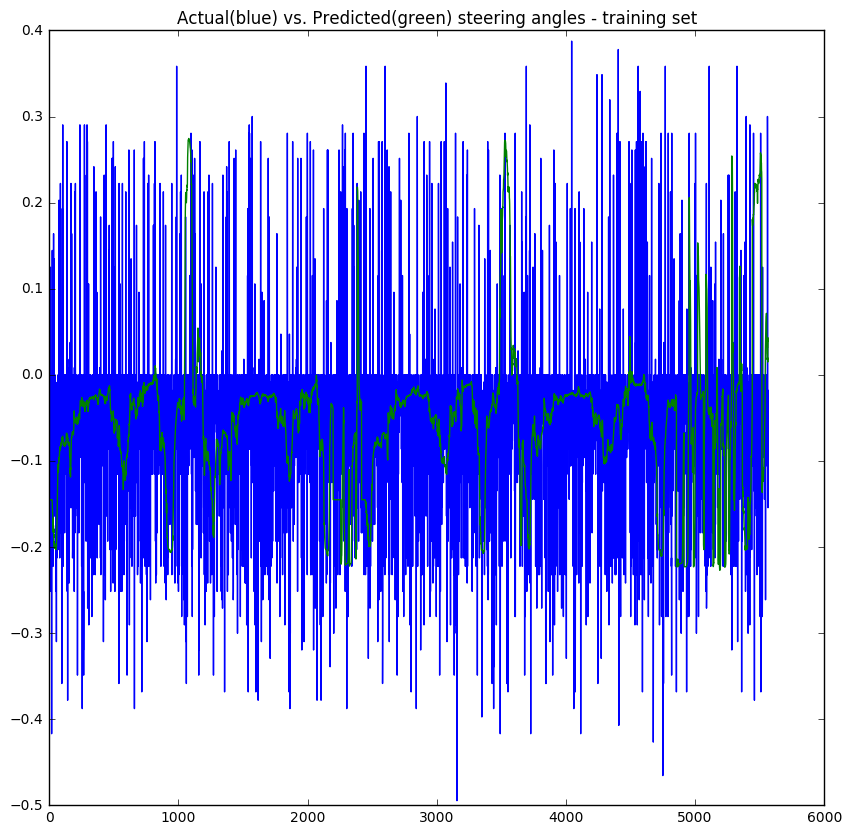

In [100]:

plt.figure(figsize=(10,10))
plt.plot(y_train_r,color='b')
plt.plot(y_train_predict,color='g')

plt.title("Actual(blue) vs. Predicted(green) steering angles - training set")

In [ ]:
y_val_predict = model.predict(X_val)

In [ ]:
plt.plot(y_val, color='b')
plt.plot(y_val_predict, color='g')
plt.title("Actual(blue) vs. Predicted(green) steering angles - validation set")


In [ ]:
plt.scatter(y_train_predict,y_train,alpha=0.1)
plt.title("Prediction correlation on training set")

In [ ]:
plt.scatter(y_val_predict,y_val,alpha=0.1)
plt.title("Prediction correlation on validation set")

In [ ]:
#model.save('model_a_v00304.h5')
def save_model_to_json(model, file_path='model.json'):
    json = model.to_json()
    with open(file_path, 'w') as f:
        f.write(json)
        
def save_weights(model, file_path='model.h5'):
    model.save_weights(file_path)

def save_all():
    save_model_to_json(model)
    save_weights(model)



In [ ]:
save_all()